# <b>IdentiBreed - The dog breed identification AI</b>

<p align="center">
    <img src="./resources/images/banner_color.png" >
</p>

In this notebook I will go through an entire workflow of my first Neural Network/Deep Learning model. The ultimate goal of this project is creating an answer (a late submission which will allow me to measure the actual performance of the model) to the "Dog Breed Identification" competition available on Kaggle under <a href="https://www.kaggle.com/competitions/dog-breed-identification">this link</a>. 

Originally this was a project from a Udemy course I was taking. Since then I expanded on this topic, made some improvements and further experimented with the model. At this stage there's only one model built - it's a transfer learning model using an import from TensorFlow Hub. At later stage I would like to attempt to create my own model from ground up.

If you've seen any of my previous projects on my <a href="https://github.com/Ale-Cie">GitHub</a> you can expect the typical framework - The notebook will follow loosely these few steps:
 - Defining the problem - Kaggle did that actually for me. We can read on the competition's page that this is a multi-class classification problem
 - Exploring the data
 - Create initial model(s) and tune the hyperparameters - to that end I will use TensorFlow and TensorFlow Hub
 - Evaluate the model(s) 
 - Experiment untill satisfied 


This notebook was originally created, edited and trained on Google Colaboratory. However due to the limited GPU usage, session timeouts and overall better performance of my computer I decided on migrating it onto my machine and training it locally. Any training or prediction times visible below should be taken with a grain of salt - my M1 Macbook Air performed surprisingly well which is not a guarantee on other machines.

Let's commence...


## Getting the workspace ready

Let's start by importing the necessary tools and launching a TensorBoard session

In [1]:

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

from IPython.display import Image
from sklearn.model_selection import train_test_split

%load_ext tensorboard



### Getting the dataset ready

Since this notebook will be posted on Kaggle as well, I have to future-proof it by creating a `try` and `expect` for loading in the dataset. At this stage I will also created three variables:
 - `unique_lables` - this will be a list of all the dog breeds available in the data set
 - `bool_labels` - this will be a list of lists. Each list within this variable will correspond to an 'id' and which of the indexes of `unique_labels` represents its breed (this will help us with training the model)
 - `train_file_paths` - this will be a list containing all paths to training images

After declaring these variables we will take a look at the value counts of instances of each breed within this dataset.

In [2]:
try:
    labels_csv = pd.read_csv("./data/labels.csv")
except:
    labels_csv = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")

labels_csv

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


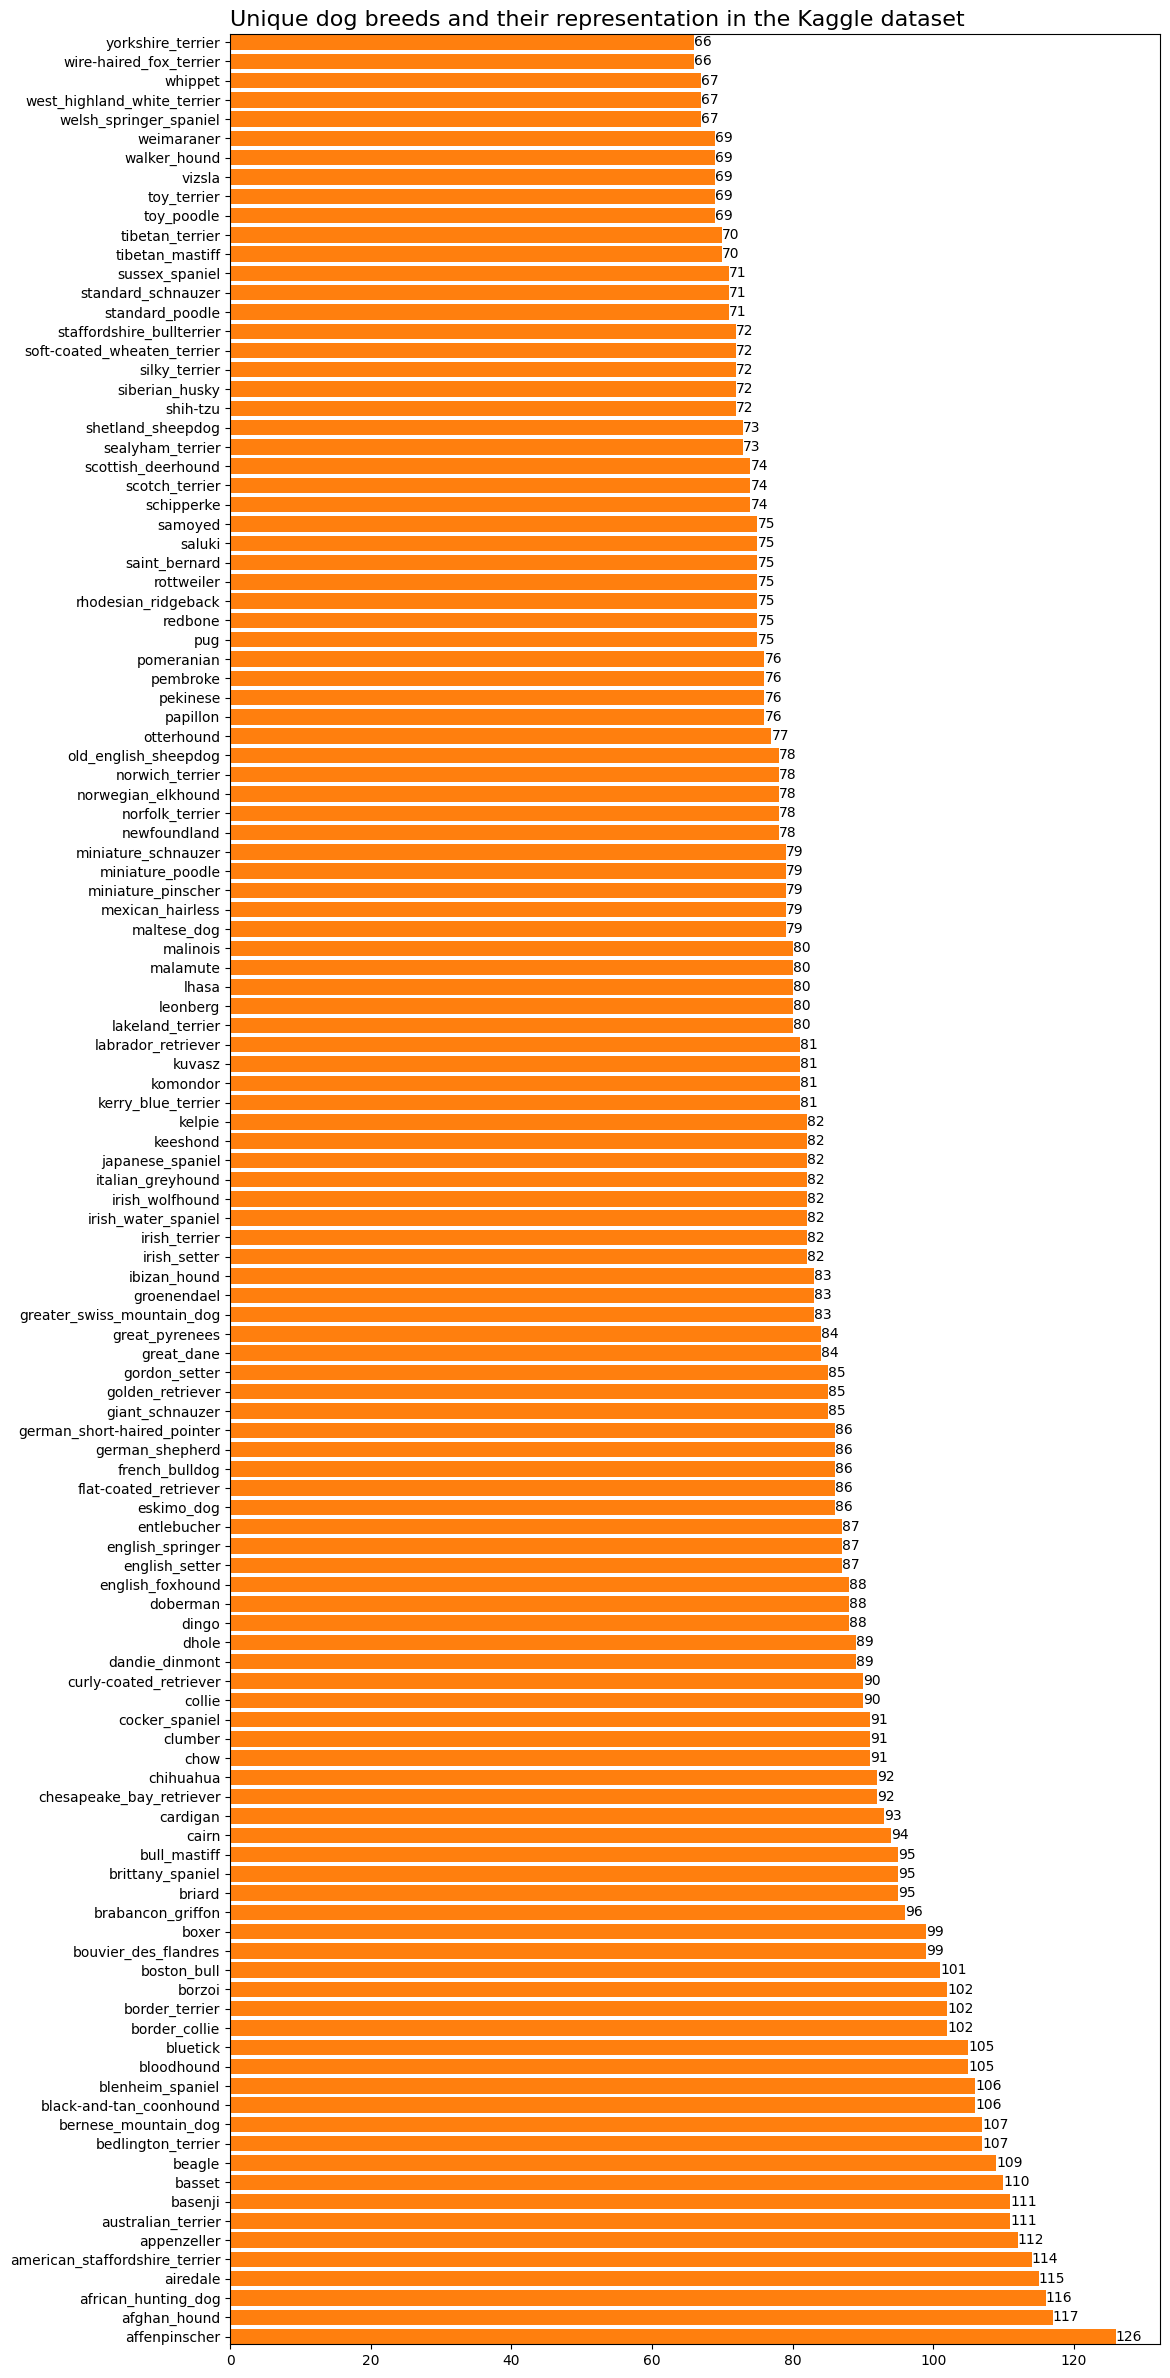

In [3]:
fig, ax = plt.subplots(figsize=(12, 30))
plt.barh(
    y=np.unique(labels_csv["breed"]),
    width=labels_csv["breed"].value_counts(),
    color= "tab:orange")
plt.margins(y=0)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Unique dog breeds and their representation in the Kaggle dataset", loc="left", fontdict={"fontsize": 16});



In [4]:
# Here we create a list of 120 unique breeds in the dataset
unique_labels = np.unique(np.array(labels_csv["breed"]))

# Now we go through the whole dataset and create a boolean representation of each training image's breed, I will later show what I mean
bool_labels = [label == unique_labels for label in labels_csv["breed"]]

# Now let's create a variable which contains all paths to image files. We have to Kaggle-proof it as well
try:
    train_file_paths = [f"./data/train/{id}.jpg" for id in labels_csv["id"]]
except:
    train_file_paths = [f"/kaggle/input/dog-breed-identification/train/{id}.jpg" for id in labels_csv["id"]]

In order to explain what's the purpose of the `bool_labels` variable let's look at the example below. 

1. I start by printing the first item in the list `bool_labels` (which corresponds to the first item in the `labels_csv`) DataFrame - it's a list consisting of 120 boolean values. This amount is not accidental, since it's the exactly the same number as the the length of the `unique_labels` variable
2. Next I will locate which index has the `True` value. In the same cell I will check what breed is saved in the `unique_labels` variable under this index and if it matches the true label of this particular image (we can check it in the 0 index row of `labels_csv`)

In [5]:
# 1.
print(bool_labels[0]), print(f"The length of 'unique_labels' is {len(unique_labels)}")

[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
The length of 'unique_labels' is 120


(None, None)

In [6]:
# 2.
idx = np.argwhere(bool_labels[0]==True)

print(f"The True label is at index {idx}") 
print(f"In 'unique_labels' under index {idx} is a breed - {unique_labels[idx]}")
print(f"The actual label is {labels_csv['breed'][0]}")

The True label is at index [[19]]
In 'unique_labels' under index [[19]] is a breed - [['boston_bull']]
The actual label is boston_bull


## Preparing the data for modelling

Kaggle in this competition provides us with train and test folders - images in the test folder being unlabeled. These pictures will have to be labeled by our trained model and creating a late submission will give us a final verdict on the models performance. 

We have to split the train images into a train set and validation set with `train_test_split()`, setting the `test_size` parameter to 0.2 and `random_state` to a number, which will make this notebook reproducable.

Initial training and experimenting will be done on a fraction of the dataset. Let's create a parameter that we can change as we need

In [7]:
# On Colab this @param decorator (?) created a  slider that could increase/decrease the amount of images used in following cells
# Let's ignore it and just leave it at a 1000 for now

IMG_NUM = 1000 #@param {type:"slider", min:1000, max:10222}

In [8]:
# We start by creating X and y variables which correspond to previouly declared ones 
X = train_file_paths
y = bool_labels

# Now it's time to split the data into train and validation sets
# In total the amount of images in these will add up to the IMG_NUM
X_train, X_validation, y_train, y_validation = train_test_split(X[:IMG_NUM], y[:IMG_NUM], test_size=0.2, random_state=7821)

len(X_train), len(y_train), len(X_validation), len(y_validation)


(800, 800, 200, 200)

### Turning images into Tensors

In this notebook I will define functions as I go. I might attempt to make an abridged version of this with all functions moved to an external .py file, but that's a job for a later date.

We start by creating a function that will load each image from the path provided and turn it into a tensor. 

The second function defined will take a tensor and a label corresponding to it and put them in a pair. That will help us with creating batches and training the model.

In [9]:
# This is yet another variable that can be changed depending on preferences and (in this case) model used
IMG_SIZE = 224

def turn_to_tensor(img_path, img_size=IMG_SIZE):
  """
  This function takes an image path and uses it to load in an image and turn it into a Tensor.
  Then it converts the dtype and resizes the image to img_size x img_size

  Returns a normalized Tensor
  """

  # Load in the image file and turn it into a numerical Tensor
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)

  # Normalizing the image and resizing it to a constant (244x244)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, size=(img_size, img_size))

  return img

def create_tensor_img_tuple(img_path, label):
  """
  This function takes an image path and its corresponding label. 
  Then it turns the image from path provided into a Tensor. 

  Returns a tuple - (Tensor, label)
  """

  image = turn_to_tensor(img_path)
  
  return image, label


### Dividing data into minibatches

Using the two functions from above we can go ahead and start splitting the images into minibatches that we will later feed to the model. 

We will start by defining yet another function - `minibatch_maker`. We will be able to use it at every stage of experimentation since it will distinguish between training, validation and testing sets. 

First however we declare another variable `BATCH_SIZE` with value of 32. As Yann LeCun says:
    
    "[...] Friends dont let friends use minibatches larger than 32"

In [10]:
# We could change that, but I'm leaving it as is
BATCH_SIZE = 32

def minibatch_maker(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates data batches out of image and label pairs (X and y pairs).
  Shuffles the data if it's training data.
  Doesn't shuffle if it's validation data.
  Accepts the Kaggle test data.

  Returns a data batch
  """

  if test_data:
    # I commented out the line below because it was really annoying when I started tossing single images at the model to test it IRL
    #print("Splitting test data into batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(turn_to_tensor).batch(batch_size)
    return data_batch
  elif valid_data:
    print("Splitting validation data into batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(create_tensor_img_tuple).batch(batch_size)
    return data_batch
  else:
    # This one we want to shuffle
    np.random.seed(7821)
    print("Splitting training data into batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(create_tensor_img_tuple).batch(batch_size)
    return data_batch


In [11]:
# Let's create train and validation batches now

train_data = minibatch_maker(X_train, y_train)
validation_data = minibatch_maker(X_validation, y_validation, valid_data=True)

Splitting training data into batches
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Splitting validation data into batches


## Building a model

We will start by defining variables that will later come in handy when creating a model.

Right now we have to declare the input shape that will be fed into the first layer of our Neural Network and the output shape we are expecting to get. 

 - `INPUT_SHAPE` will be equal to the dimensions of each image and will contain the information about the colour channels
 - `OUTPUT_SHAPE` will be simply an array of 120 values

The final variable that we will declare is the `MODEL_URL` which is a link to a MobileNet V2 model from the TensorFlow Hub


In [12]:
# Input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Output shape
OUTPUT_SHAPE = len(unique_labels)

# TensorFlow model URL
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now that we now what our inputs and outputs look like it's time to define a function that will create model with the settings we want to use.

In [13]:
# Creating a model instantiating function

def build_network(input_shape= INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url= MODEL_URL):
  """
  This function can take an input_shape, output_shape and a model_url in order to create a Neural Network.
  Network created by this function has '2' layers:
   - Input Layer
   - Output Layer, which outputs data in the shape of output_shape
  Any other layers present are hidden within the imported model.

  Returns a network
  """
  model = tf.keras.Sequential([
      hub.KerasLayer(
        model_url, 
        name="InputLayer"
      ), # Layer 1 - Input layer
      tf.keras.layers.Dense(
        units= output_shape, 
        activation= "softmax",
        name= "OutputLayer"
      ) # Layer 2 - Output layer 

  ])

  model.compile(
      loss= tf.keras.losses.CategoricalCrossentropy(),
      optimizer= tf.keras.optimizers.Adam(),
      metrics= ["accuracy"]
  )

  model.build(input_shape)

  return model

In [14]:
model = build_network()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (KerasLayer)     (None, 1001)              5432713   
                                                                 
 OutputLayer (Dense)         (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating callbacks

Next step to take is creating callbacks - we will create only two. One of them will allow us to make checkopints during training, which will save us if anything goes terribly wrong and the whole procedure fails. The second callback will (hopefully) prevent the model from overfitting by checking if the accuracy is not improving for three consecutive epochs. 

In [15]:
def tensorboard_callback():
  """
  Creates checkpoints and saves them in a /logs folder under the date of creation.

  Returns a TensorBoard callback
  """
  try:
    logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  except:
    logdir = os.path.join("/kaggle/working/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience= 3)

## Training the model

We are starting slow with the number of images previously declared as `IMG_NUM` variable (1000). Before training anything however I will declare yet another variable - `NUM_EPOCHS` which as the name suggests will decide on the number of training epochs that will take place during fitting.

In [16]:
# It used to be a slider on Colab, now it's just a shadow of its former glory
NUM_EPOCHS = 100 #@param {type: "slider", min: 10, max: 150, step: 10 }

In [17]:
def train_model():
  """
  This function creates an instance of the Neural Netowrk, assigns the TensorBoard callback and fits the newly created network.

  Returns a trained network
  """
  model = build_network() # I'm not passing anything into the function since all the default values are set previously in the notebook
  tensorboard = tensorboard_callback()

  model.fit(
    x= train_data, # Here we give the batches of image tensors and their labels
    epochs= NUM_EPOCHS,
    validation_data= validation_data,
    validation_freq=1,
    callbacks=[tensorboard, early_stopping])
  
  return model

In [18]:
model = train_model()

Epoch 1/100


2023-05-11 14:21:53.300259: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 8s 243ms/step - loss: 4.5784 - accuracy: 0.0938 - val_loss: 3.2578 - val_accuracy: 0.2900
Epoch 2/100
25/25 [==============================] - 5s 215ms/step - loss: 1.6163 - accuracy: 0.7000 - val_loss: 2.0236 - val_accuracy: 0.5500
Epoch 3/100
25/25 [==============================] - 5s 214ms/step - loss: 0.5503 - accuracy: 0.9475 - val_loss: 1.5767 - val_accuracy: 0.6500
Epoch 4/100
25/25 [==============================] - 5s 213ms/step - loss: 0.2439 - accuracy: 0.9925 - val_loss: 1.4128 - val_accuracy: 0.6850
Epoch 5/100
25/25 [==============================] - 5s 214ms/step - loss: 0.1412 - accuracy: 1.0000 - val_loss: 1.3374 - val_accuracy: 0.6700
Epoch 6/100
25/25 [==============================] - 5s 214ms/step - loss: 0.0965 - accuracy: 1.0000 - val_loss: 1.3035 - val_accuracy: 0.6800
Epoch 7/100
25/25 [==============================] - 5s 215ms/step - loss: 0.0722 - accuracy: 1.0000 - val_loss: 1.2876 - val_accuracy: 0.6750


## Making predictions on the validation set

Now that we have a trained neural network we can make predictions on the validation set and see how well it does. We will have to however put in a little elbow grease (or digit grease rather) to turn the prediction probabilities into actual dog breed names.

In [19]:
# We start by making predictions which is fairly straight forward
pred_probabilities = model.predict(validation_data, verbose=1)

pred_probabilities

7/7 [==============================] - 2s 225ms/step


array([[6.05699187e-03, 1.77003458e-05, 2.47159187e-04, ...,
        2.17800945e-04, 3.11361830e-04, 2.11136770e-02],
       [4.12049740e-05, 1.00020634e-05, 5.78974956e-04, ...,
        7.53123823e-05, 1.80459392e-06, 7.40563200e-06],
       [1.36778376e-03, 2.06093580e-04, 8.59657739e-05, ...,
        1.97986010e-04, 8.63765483e-04, 3.70715469e-01],
       ...,
       [4.32795088e-04, 8.16241745e-03, 2.47601914e-04, ...,
        1.71452435e-03, 3.13409185e-03, 1.12910022e-03],
       [4.81498661e-04, 3.96529183e-04, 1.03013714e-04, ...,
        8.45468836e-04, 2.36603344e-04, 1.52491138e-03],
       [5.45453327e-03, 1.10640685e-05, 7.89867336e-05, ...,
        3.95887735e-04, 4.53269621e-03, 1.73054133e-02]], dtype=float32)

In [20]:
def name_predicted_label(probabilities):
  """
  This function takes a list of 120 probabilities, finds the index of the most probable one and searches 'unique_labels' for the corresponding name

  Returns the breed name
  """

  return unique_labels[np.argmax(probabilities)]

def unbatch_data(batched_data):
  """
  This function takes a data batch and unbatches it into an ordered list of images, and another ordered list of corresponding true labels

  Returns images list and labels list
  """

  images = []
  labels = []

  for image, label in batched_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])

  return images, labels

In [21]:
val_images, val_labels = unbatch_data(validation_data)

In [22]:
def display_prediction(prediction_probabilities, labels, images, n=0):
  """
  This function takes a list of prediction probabilities, list of labels, list of images and an index. 
  It plots the result of models prediction - it displays the image of the dog with predicted breed, the probability and an actual label.
  If the prediction was right, the text will appear in green. Else it will be red
  """

  n = 0 if n > len(prediction_probabilities) else n
  probabilities, true_label, image = prediction_probabilities[n], labels[n], images[n]

  pred_label = name_predicted_label(probabilities)

  if pred_label == true_label:
    t_color = "tab:green"
  else:
    t_color = "tab:red"

  plt.imshow(image)
  plt.title("{} {:0.3f}% {}".format(
      pred_label,
      np.max(probabilities)*100,
      true_label),
      color= t_color)
  plt.xticks([])
  plt.yticks([])


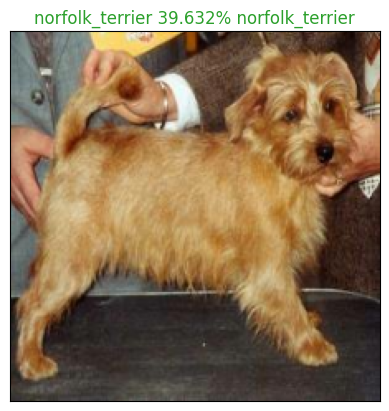

In [23]:
display_prediction(
    prediction_probabilities=pred_probabilities,
    labels= val_labels,
    images= val_images
)

In [24]:
def plot_k_confidences(prediction_probabilities, labels, k=5, n=0):
  """
  This function takes list of prediction probabilites, list of dog breed labels.
  Optionally it takes:
   - 'k' - a variable specifying how many highest probabilites to plot
   - 'n' - a specific index of an image to check for prediction and an actual label
  """
  n = 0 if n > len(prediction_probabilities) else n
  pred_probabilities, true_label = prediction_probabilities[n], labels[n]

  # pred_label = name_predicted_label(pred_probabilities)

  top_k_idx = pred_probabilities.argsort()[-k:][::-1]
  top_k_confidences = pred_probabilities[top_k_idx]
  top_k_labels = unique_labels[top_k_idx]

  top_k_plot = plt.bar(np.arange(len(top_k_labels)),
                     top_k_confidences,
                     color="grey")
  plt.xticks(np.arange(len(top_k_labels)),
             labels=top_k_labels,
             rotation="vertical")
  
  if np.isin(true_label, top_k_labels):
    top_k_plot[np.argmax(top_k_labels == true_label)].set_color("tab:green")
  else:
    pass


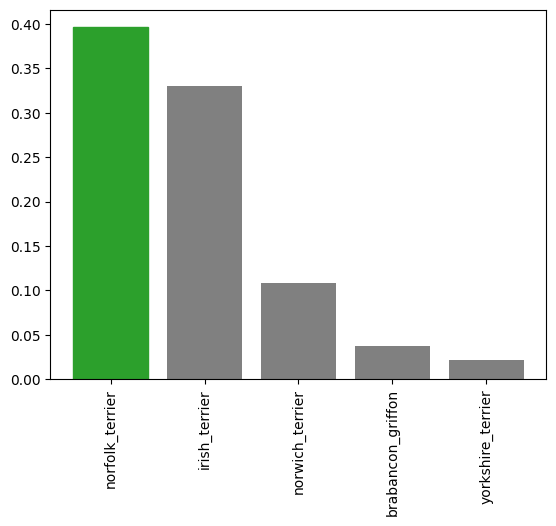

In [25]:
plot_k_confidences(
    prediction_probabilities=pred_probabilities,
    labels= val_labels
    )

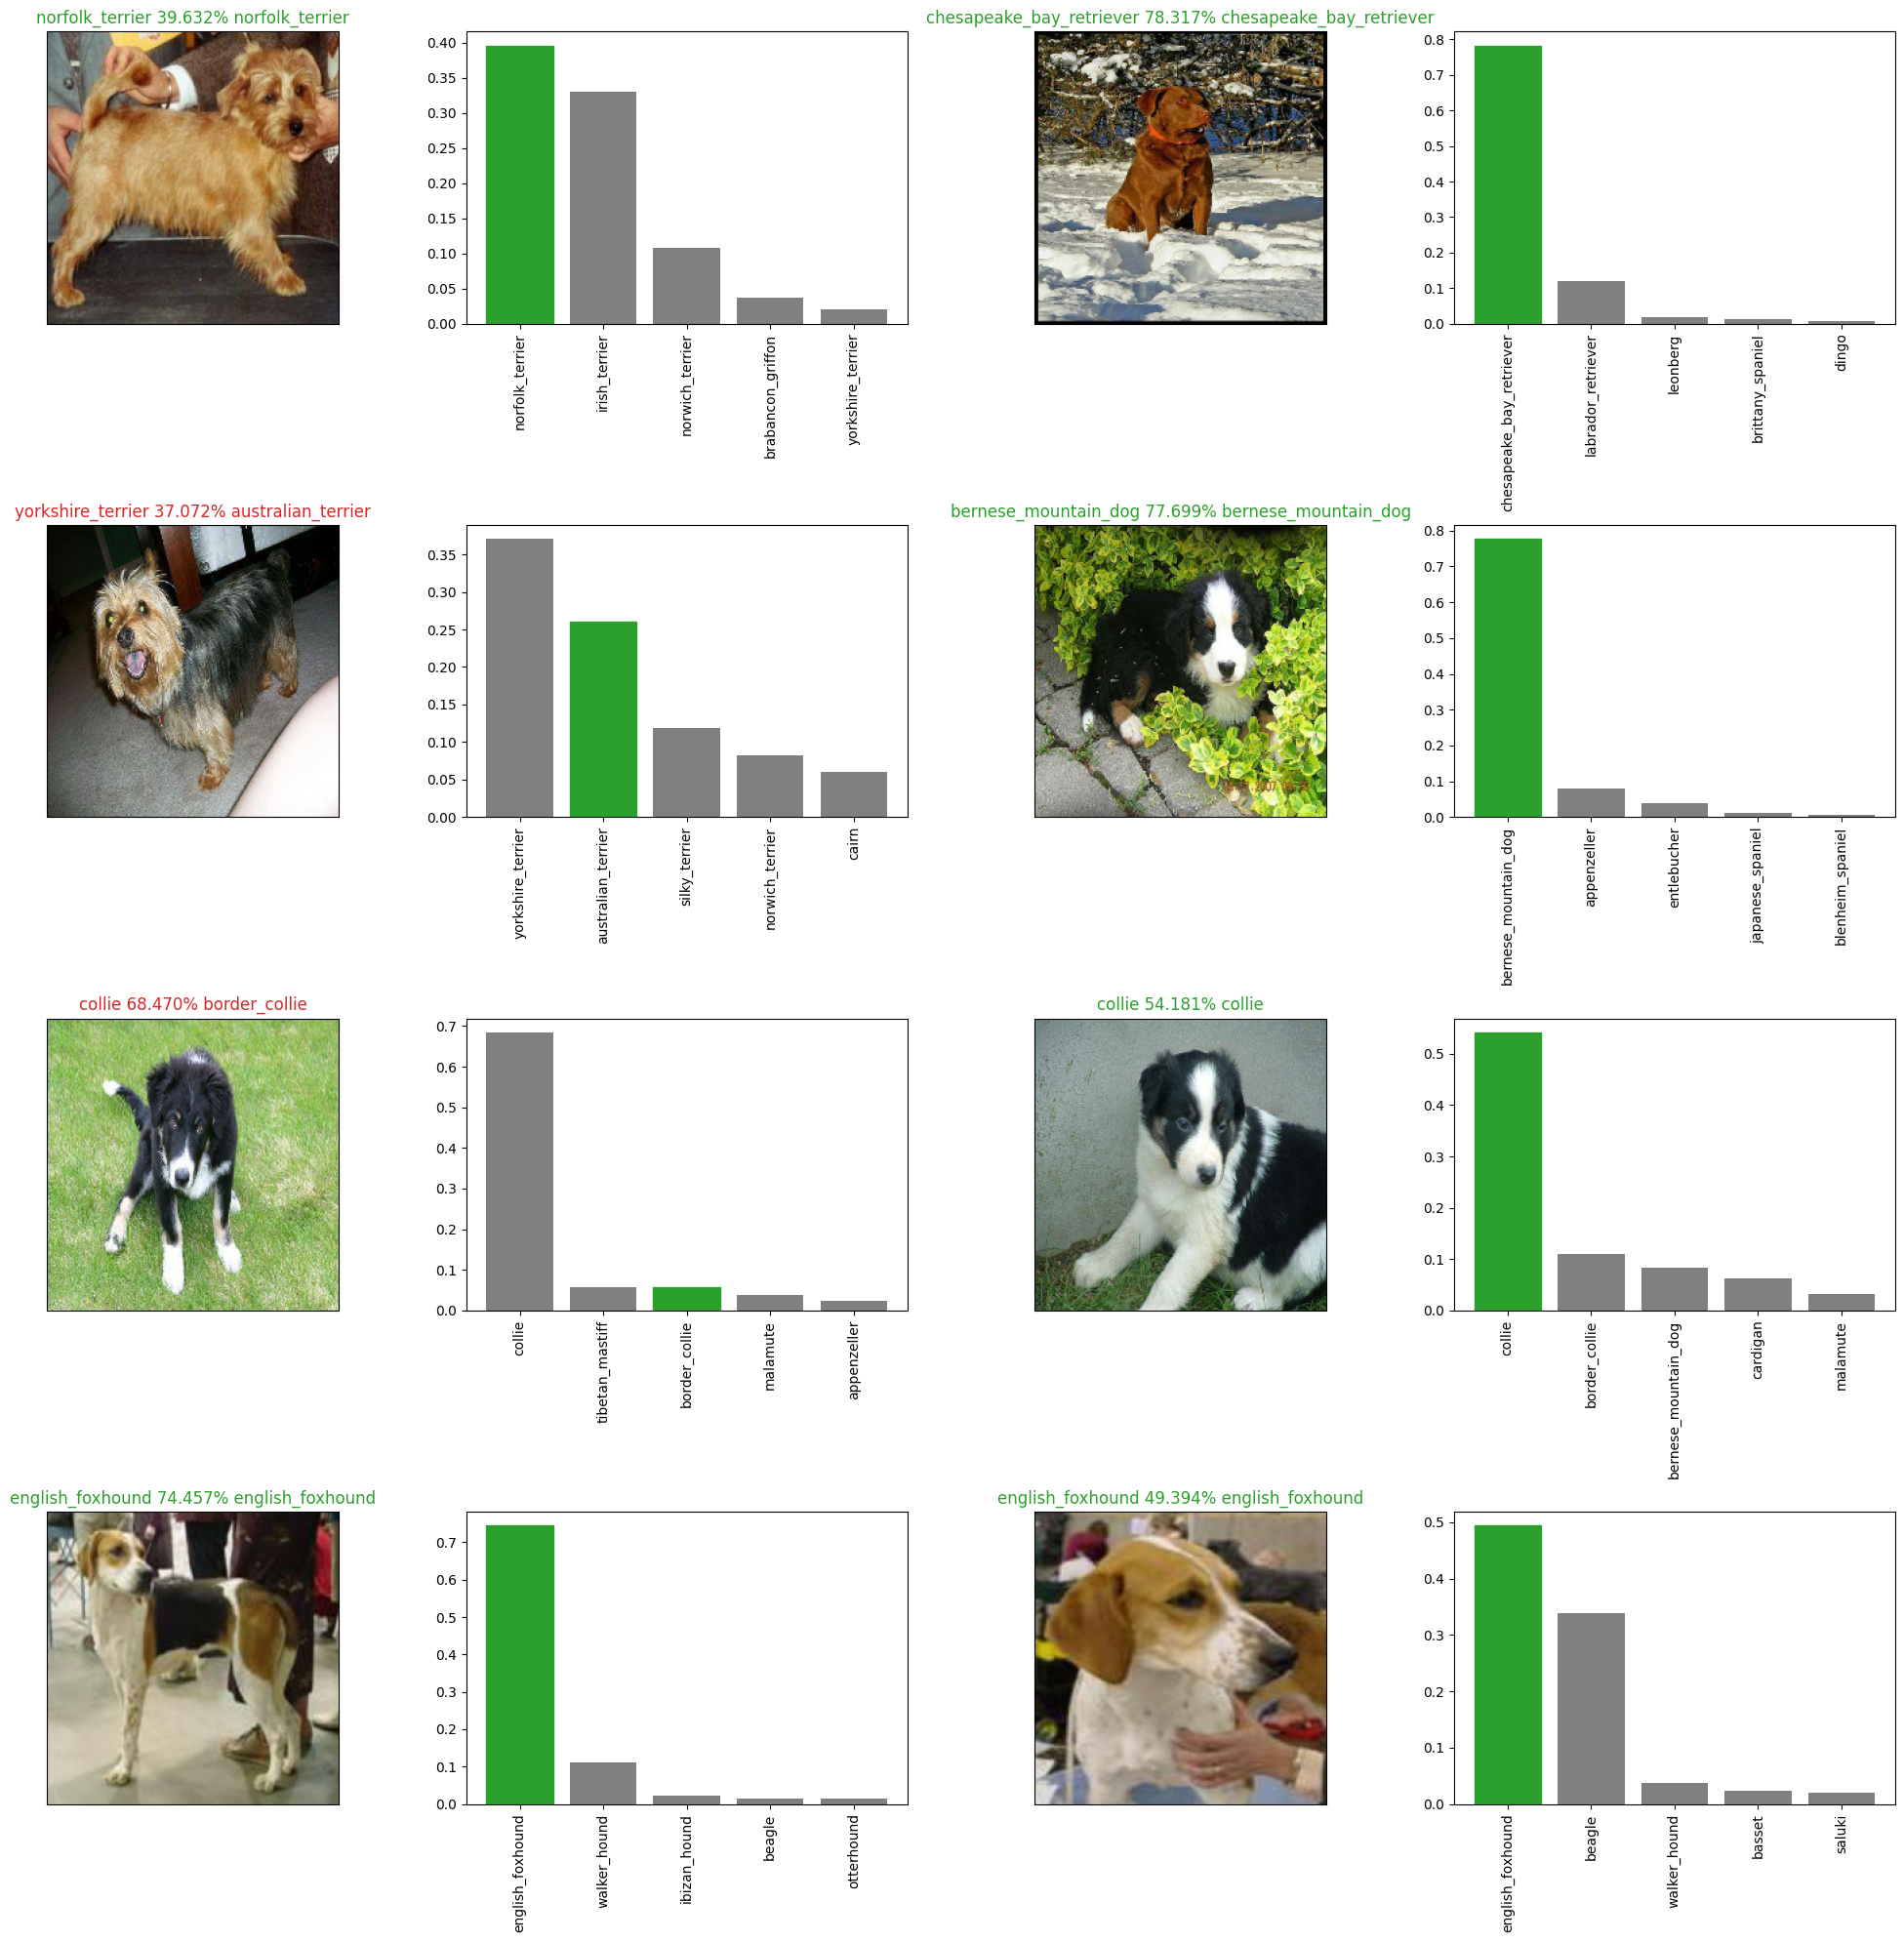

In [26]:
def plot_k_predictions(prediction_probabilities, labels, images, i_multiplier=0, n_rows= 4, n_cols= 2, k=5):
  """
  This function creates a figure showing different predictions and the top probabilities. 
  It takes following arguments:
   - prediction_probabilities - an ordered list of probabilities created by the model
   - labels - an ordered list of actual labels for the dataset on which predictions were made
   - images - an ordered list of tensors, on which predictions were made
  
  Optional arguments:
   - i_multiplier - int that makes the function show next images
   - n_rows - int specifying how many rows of predictions to describe
   - n_cols - int specifying how many columns of predictions to describe
   - k - int specifying how many top prediction values to plot
  """

  n_images = n_rows * n_cols

  plt.figure(figsize=(10*n_cols, 5*n_rows))
  for i in range(n_images):
    plt.subplot(n_rows, 2*n_cols, 2*i+1)
    display_prediction(
        prediction_probabilities= prediction_probabilities,
        labels = labels,
        images = images,
        n = i+i_multiplier
    )
    plt.subplot(n_rows, 2*n_cols, 2*i+2)
    plot_k_confidences(
        prediction_probabilities= prediction_probabilities,
        labels = labels,
        k= k,
        n= i+i_multiplier,
    )
  plt.tight_layout(h_pad=1.0)
  plt.show()

plot_k_predictions(
  prediction_probabilities=pred_probabilities, 
  labels=val_labels, 
  images=val_images
  )



## Saving the model

In [27]:
def save_model(model, suffix=None):
  """
  Saves the model in the ./models directory. It takes two arguments:
   - model - the actual model to be saved
   - suffix (optional) - any user defined string that describes the model and will be attached to the file name for identification purposes

  Returns path to the saved .h5 file
  """
  try:
    modeldir = os.path.join("./models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  except:  
    modeldir = os.path.join("/kaggle/working/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s")) 
  model_path = modeldir + "-" + suffix + ".h5"

  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  
  return model_path

def load_model(model_path):
  """
  Loads the model from the .h5 file under 'model_path'

  Returns model
  """
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  
  return model

In [28]:
save_model(
    model= model, 
    suffix="1000-imgs-MobileNetV2-Adam-New"
    )

Saving model to: ./models/20230511-14231683807813-1000-imgs-MobileNetV2-Adam-New.h5...


'./models/20230511-14231683807813-1000-imgs-MobileNetV2-Adam-New.h5'

## Training model on the full data set

Now that we have experimented a bit on the model with just the 1000 images, we can go on and train a new instance of the model using the whole set of images. 

To begin we have to create a new data batch using all of the images and the corresponding labels and then feed it into the model.

Before we fit the model however we have to create a new `EarlyStopping` callback, because we don't want to use a validation set this time around. 

In [29]:
full_data = minibatch_maker(
    X= X,
    y= y,
)

Splitting training data into batches


In [30]:
full_model = build_network()

In [31]:
full_model_tensorboard = tensorboard_callback()

# This time around we will only monitor the accuracy of the model
# However we will still stop training once the model stops improving for three epochs
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [32]:
full_model.fit(
    x= full_data,
    epochs= NUM_EPOCHS,
    callbacks = [full_model_tensorboard, full_model_early_stopping]
)

Epoch 1/100
320/320 [==============================] - 57s 172ms/step - loss: 1.3290 - accuracy: 0.6742
Epoch 2/100
320/320 [==============================] - 55s 171ms/step - loss: 0.4018 - accuracy: 0.8795
Epoch 3/100
320/320 [==============================] - 55s 171ms/step - loss: 0.2346 - accuracy: 0.9368
Epoch 4/100
320/320 [==============================] - 56s 174ms/step - loss: 0.1504 - accuracy: 0.9649
Epoch 5/100
320/320 [==============================] - 56s 174ms/step - loss: 0.1064 - accuracy: 0.9785
Epoch 6/100
320/320 [==============================] - 56s 176ms/step - loss: 0.0767 - accuracy: 0.9868
Epoch 7/100
320/320 [==============================] - 85s 267ms/step - loss: 0.0583 - accuracy: 0.9915
Epoch 8/100
320/320 [==============================] - 55s 172ms/step - loss: 0.0455 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 57s 177ms/step - loss: 0.0383 - accuracy: 0.9957
Epoch 10/100
320/320 [==============================] - 58s 180m

Now that we have finally (nearly 15 minuts on my MacBook) trained the model on the entire dataset we can save it for posterity. 

The model claims it's accuracy is about 98% (97.94% allegedly) but we can't really tell how good it performs until we test it in the real world scenario. For that we will use the test dataset provided, translate the predictions into labels and put them in the format that Kaggle specified on the competition page. Posting a late submission will tell us how good this model performed. I'll update this notebook with the score below.

In [34]:
save_model(
    model= full_model, 
    suffix= "full-image-set-MobileNetV2-Adam-v2"
    )

Saving model to: ./models/20230511-14531683809630-full-image-set-MobileNetV2-Adam-v2.h5...


'./models/20230511-14531683809630-full-image-set-MobileNetV2-Adam-v2.h5'

## Making predictions on test data

In order to make the predictions we have to start all over again - we have to create a list of file paths to the test images, create batches of data and feed them into the model.

Making batches differs this time however - we have to make sure to set the `test_data` argument in the `minibatch_maker()` function to `True`

In [35]:
try:
    test_files = os.listdir("./data/test")
    try:
        test_files.remove("test.txt")
    except:
        print("No 'test.txt' file located. Creating X_test list")
    X_test = [f"./data/test/{file}" for file in test_files]
except:
    test_files = os.listdir("/kaggle/input/dog-breed-identification/test")
    try:
        test_files.remove("test.txt")
    except:
        print("No 'test.txt' file located. Creating X_test list")
    X_test = [f"/kaggle/input/dog-breed-identification/test{file}" for file in test_files]

len(X_test)


10357

In [36]:
test_data = minibatch_maker(
    X= X_test,
    test_data= True
)

Now that we have the data ready for predicting it's time to sit down, feed the model and wait for it to finish.

In [37]:
test_predictions = full_model.predict(test_data, verbose=1)


324/324 [==============================] - 54s 166ms/step


After a little hiccough I prepared for myself when making the project GitHub ready we now have predictions, that we should save and then go on preparing for evaluation on Kaggle.

In [38]:
np.savetxt("./predictions_array.csv", test_predictions, delimiter=",")

### Preparing the predictions for Kaggle publication

Now all that is left for us to do is create a submission DataFrame that follows the guidelines presented by Kaggle on the competition <a href="https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation">page</a>.

In [39]:
def submission_maker(predictions):
    """This function takes predictions array and along with the breed names and image names puts them into a Kaggle ready DataFrame """
    # We start by creating a list of all the test images names, without the extension which starts at index -4
    global unique_labels
    index_names = [name[:-4] for name in os.listdir("./data/test/")]
    try:
        index_names.remove("test")
    except:
        print("No 'test.txt' located, preparing index_names...")

    submission = pd.DataFrame(predictions, columns=unique_labels, index=index_names)

    submission.index.name = "id"
    return submission

submission_df = submission_maker(test_predictions)
submission_df

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
266490a2b053a4a3bf68e779f28fb5a9,8.610007e-10,4.374902e-06,3.059468e-08,1.392574e-06,5.027774e-12,2.939011e-06,1.304095e-12,2.839304e-11,4.887953e-04,2.025373e-08,...,7.181509e-10,4.935212e-09,8.137799e-05,3.080580e-06,5.645965e-07,1.232922e-12,1.521402e-08,7.318573e-06,7.869778e-10,9.961689e-12
dae9fd18836d8df20989ef0101771d4b,4.925235e-03,1.080508e-04,3.848476e-06,1.176938e-07,1.186979e-07,9.773839e-09,1.416828e-03,1.643949e-09,2.068558e-08,8.566127e-10,...,1.726003e-07,2.424921e-07,1.951289e-08,3.875117e-05,1.033659e-05,1.870641e-11,5.683263e-07,4.974737e-07,2.429449e-07,1.983550e-08
079a40f22b0fad9a66f76797b62bb930,2.609354e-08,9.744448e-11,6.128136e-13,2.426437e-10,6.287194e-11,3.253272e-11,8.922139e-12,9.615846e-12,2.628475e-12,6.043046e-12,...,2.135986e-12,2.491749e-12,7.860221e-13,1.070984e-10,3.753818e-11,4.222057e-13,1.570375e-13,5.274094e-13,1.312591e-12,1.434917e-12
ab8462f9a501d362041d47582fddc9ad,1.558294e-10,6.120314e-09,7.044239e-12,3.106119e-08,4.462917e-12,7.271352e-09,4.692634e-09,1.274474e-12,4.193630e-10,7.381157e-12,...,6.408820e-10,3.844609e-10,3.014239e-10,2.704765e-08,5.312488e-11,6.216153e-08,1.507732e-09,3.903959e-11,2.887664e-13,1.355944e-07
8895089b432e020cc42e6262b5a1c2dd,1.302375e-11,1.551241e-10,1.003711e-09,9.756061e-13,7.305068e-10,2.548071e-09,4.096815e-08,8.435966e-05,6.743731e-06,2.599695e-09,...,2.427734e-10,6.467110e-09,9.038841e-11,2.224580e-12,3.426774e-11,2.728723e-08,3.761491e-09,1.437508e-08,6.719448e-09,5.335757e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e6d6ff5b33e6174158d5ab05a7eda95c,3.101012e-11,1.628567e-08,1.805534e-14,1.598567e-12,1.449753e-10,1.104574e-12,1.584009e-10,1.402832e-14,1.449055e-11,2.098398e-11,...,3.281599e-11,2.862503e-14,4.204498e-14,5.049714e-09,3.088857e-11,4.568432e-11,1.458081e-13,1.771377e-12,4.867615e-12,5.910343e-15
474a1be9d5932a9e75b28384961ad17f,1.608447e-09,6.805748e-10,7.931464e-07,5.342128e-10,1.564469e-11,5.051638e-09,5.582201e-09,2.281974e-06,6.961746e-11,1.019118e-09,...,1.374613e-09,1.782779e-07,4.678841e-09,1.219242e-08,1.741326e-09,4.784215e-10,3.210730e-08,1.918506e-08,1.333649e-10,8.996238e-11
1b7421b4d34056c04a9b2d109e503fe4,4.564356e-08,2.433600e-07,4.318676e-06,1.486528e-09,2.699351e-04,3.528679e-06,4.590845e-06,1.173367e-07,1.719145e-01,1.190609e-05,...,4.299596e-06,1.074853e-05,2.746939e-09,4.870274e-06,4.273284e-07,4.685933e-02,9.778661e-07,4.091889e-05,5.225968e-08,2.639773e-08


In [40]:
# Now after all this work we can go on and export our submission into a .csv file
submission_df.to_csv("./submissions/full_model_preds_v2.csv")

Model did quite good since it scored 0.92286 on Kaggle. Next step would be to get down and create an entirely original network, without relying on the TensorFlow Hub. It definitely is on my to-do list, but for now I feel like it's time to stop experimenting, end this notebook here and get on going with further exploration of this model in real-life scenarios.

In some time I'm going to update the github with what I hope will be a streamlined version of this notebook. I will move all the functions into a separate .py file and probably work in another .ipynb file on creating functions for the 'app' version of IdentiBreed.

If you've followed along big thanks to you, as for now I am signing out of this notebook. 